# Ideal Parameter Analysis ($\delta=3$, $\tau=1.75$, $\alpha=2$) ($\delta$ upper bound, $\tau$ upper bound)

In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sys

from datetime import datetime

sys.path.append('../../feeg_fmri_sync')

from feeg_fmri_sync.plotting import (
    plot_all_search_results_2d,
    plot_local_minima
)
from feeg_fmri_sync.search import (
    build_models,
    search_voxels
)
from feeg_fmri_sync.simulations import (
    build_model_to_fmri,
    generate_downsampled_simulated_fmri,
)
from feeg_fmri_sync.utils import (
    generate_descriptions_from_search_df,
)
from feeg_fmri_sync.vectorized_models import VectorizedHemodynamicModel

In [2]:
try_to_reuse = True
submit_to_cluster = False

## Initialize constants for Hemodynamic Modeling

In [3]:
### Initialize constants ###
sample_freq = 20
tr = 800
n_trs_skipped_at_beginning = 0
hemodynamic_response_window = 30

# Actual Values to generate data from
expected_delta = 3
expected_tau = 1.75
expected_alpha = 2

## Initialize constants for simulation

In [4]:
# Plot the generated data
# NOTE: only the first of the trials will be plotted
plot_generated_data = True

# Plot perfect data when modeling
plot_perfect_comparison = True

# noises to examine and plot when modeling
noise_range = range(1, 11)  
noises_to_plot = [3, 5, 10]

# trials we run for each condition and how many trials to plot when modeling
num_trials = 100  
num_trials_to_plot = 1

# models to examine
models_to_test = [
    {
        'name': 'downsample',
        'model': VectorizedHemodynamicModel,
        'fmri_data_generator': generate_downsampled_simulated_fmri,
    }
]

# eeg data types to use
eeg_data_options_for_fmri_generation = ['without_nans']
eeg_data_options_for_simulation = ['without_nans', 'with_nans']

## Display Generated Noise against Simulated Ground Truth

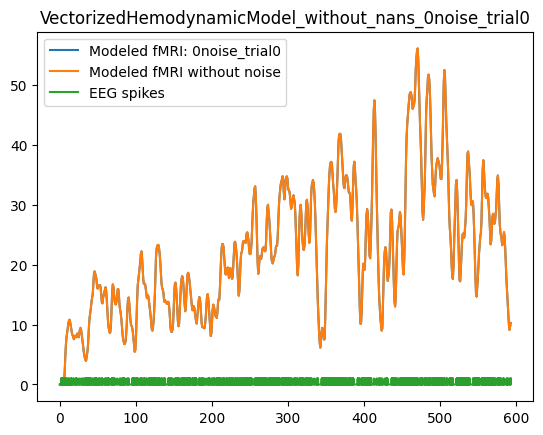

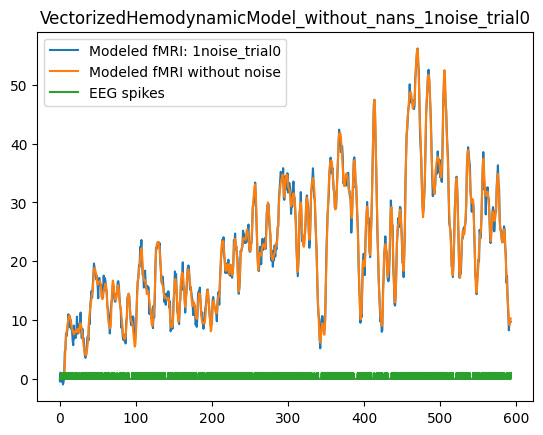

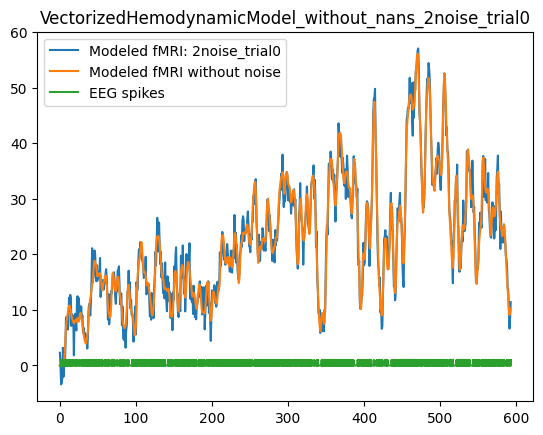

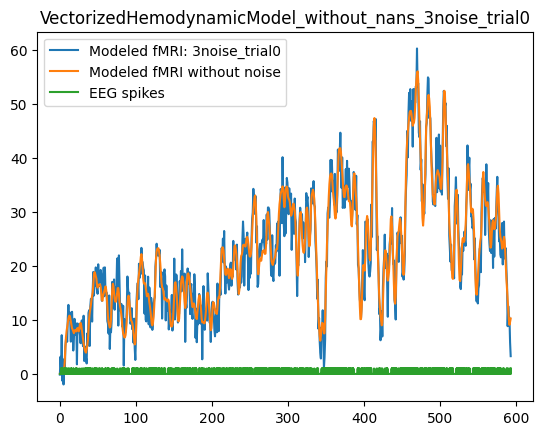

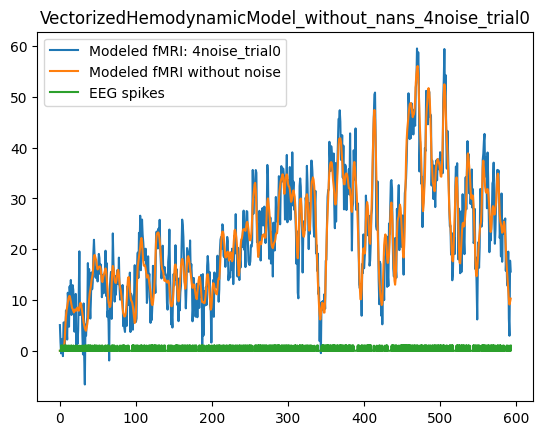

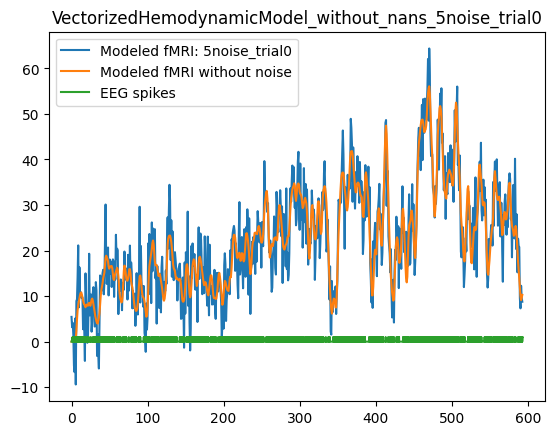

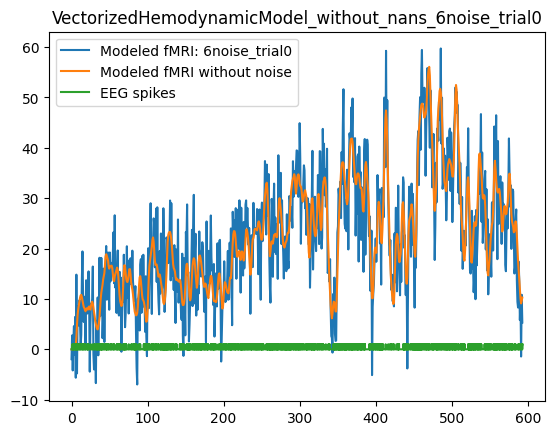

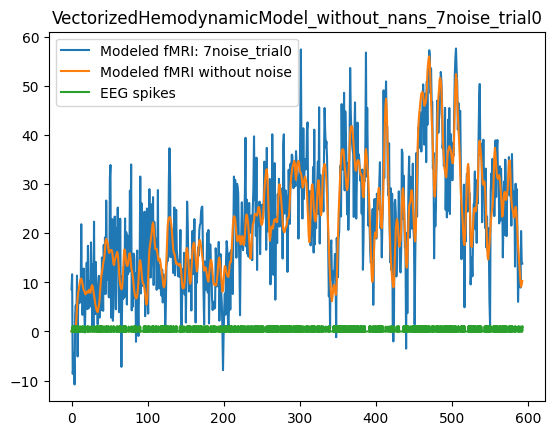

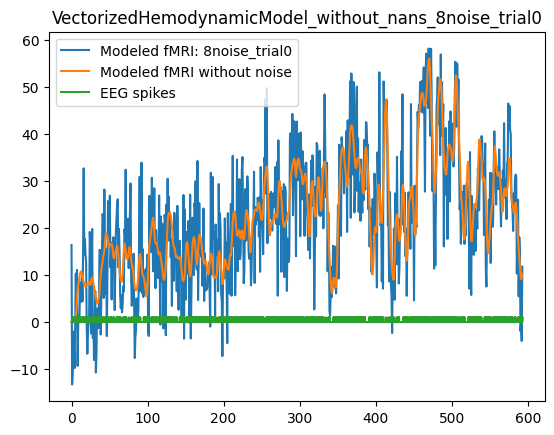

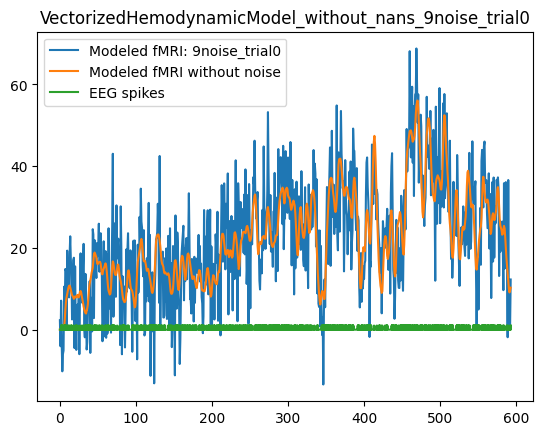

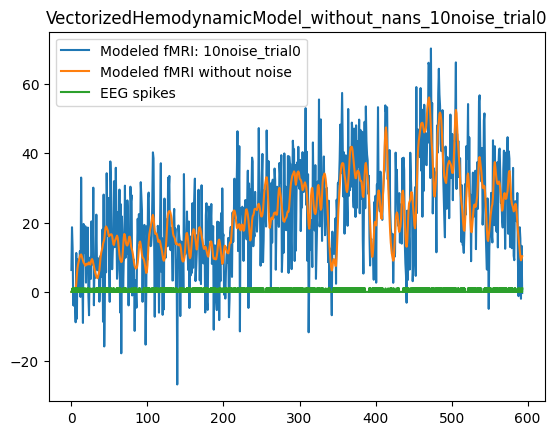

In [5]:
# Generate fMRI data
model_to_fmri = build_model_to_fmri(
    models_to_test,
    eeg_data_options_for_fmri_generation,
    expected_delta,
    expected_tau,
    expected_alpha,
    num_trials,
    num_trials_to_plot,
    noise_range,
    noises_to_plot,
    plot_perfect_comparison,
    tr,
    sample_freq,
    hemodynamic_response_window,
    plot_generated_data
)


## Initialize Analysis variables

In [6]:
step_size = 0.05

filename_substring = f'effect_of_ideal_params_delta{expected_delta}_tau{expected_tau}_alpha{expected_alpha}'
filename_ext = '.csv'
plot = True

delta = np.arange(1, 3+step_size, step_size)
tau = np.arange(0.75, 1.75+step_size, step_size)
alpha = np.arange(1.75, 2.25+step_size, step_size)

print(f'Delta target: {expected_delta}, Range:\n{delta}\n')
print(f'Tau target: {expected_tau}, Range:\n{tau}\n')
print(f'Alpha target: {expected_alpha}, Range:\n{alpha}\n')

Delta target: 3, Range:
[1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4  1.45 1.5  1.55 1.6  1.65
 1.7  1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25 2.3  2.35
 2.4  2.45 2.5  2.55 2.6  2.65 2.7  2.75 2.8  2.85 2.9  2.95 3.  ]

Tau target: 1.75, Range:
[0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4
 1.45 1.5  1.55 1.6  1.65 1.7  1.75]

Alpha target: 2, Range:
[1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25]



## Est vs Actual for all models at correct points

Scoring downsample_without_nans_without_nans delta=3, tau=1.75, alpha=2


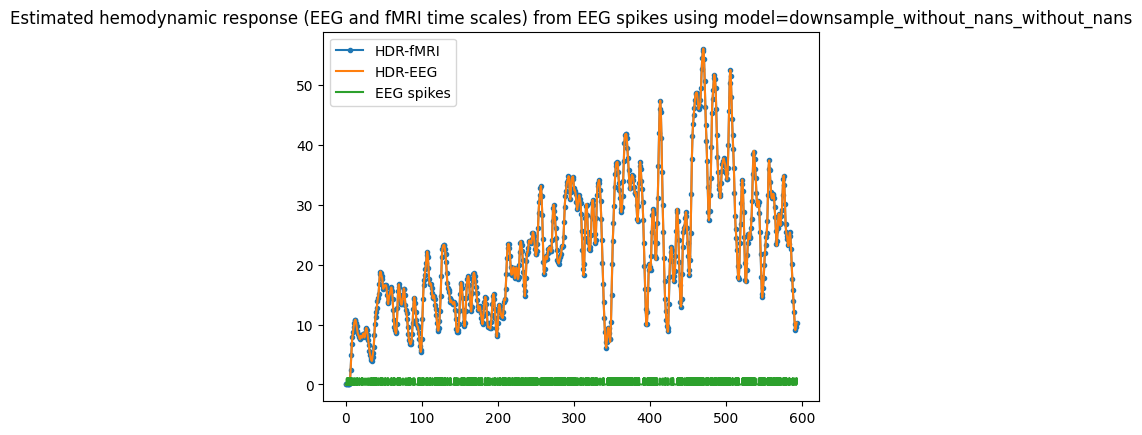

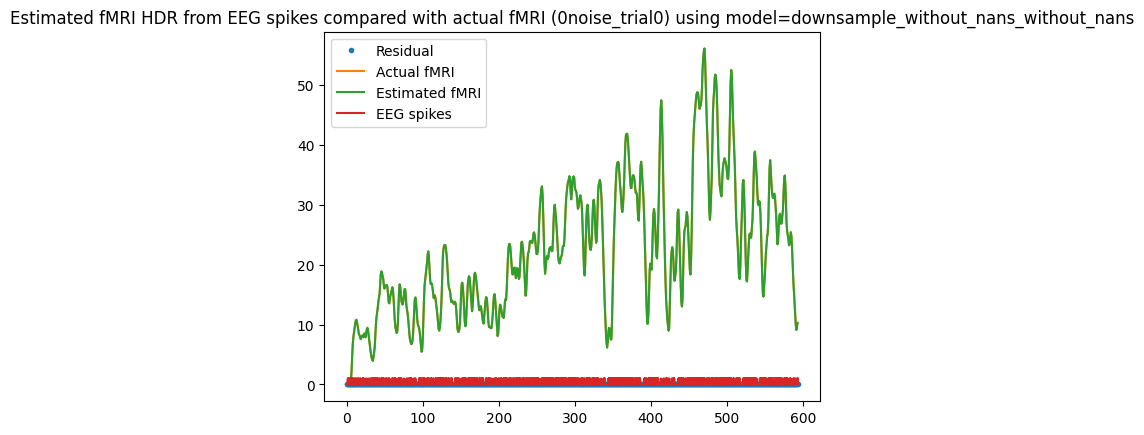

Residual Variance is 0.000000


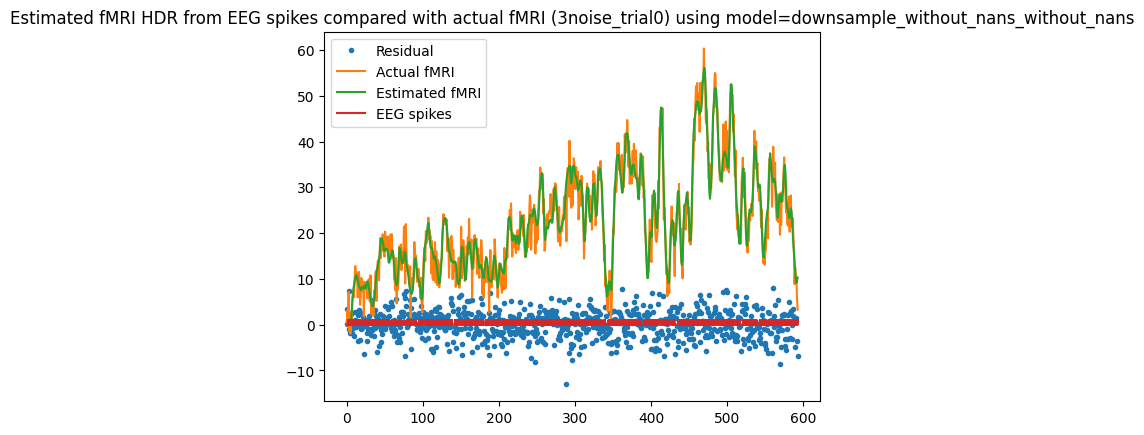

Residual Variance is 9.258633


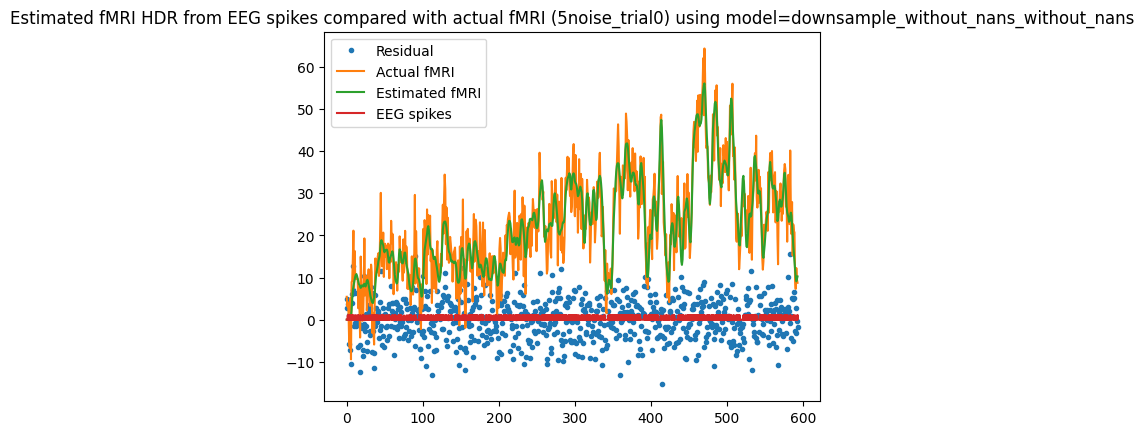

Residual Variance is 23.823901


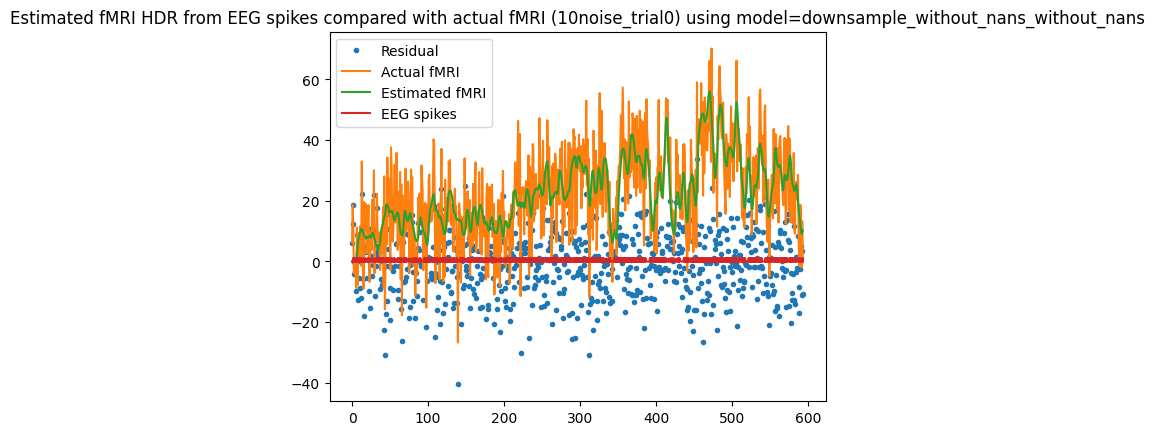

Residual Variance is 114.957705


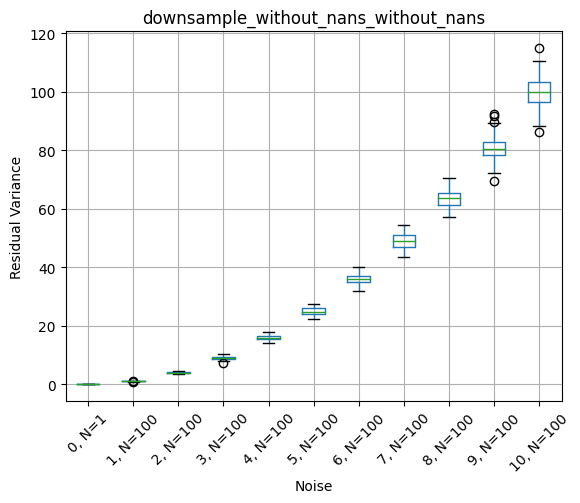

Scoring downsample_without_nans_with_nans delta=3, tau=1.75, alpha=2


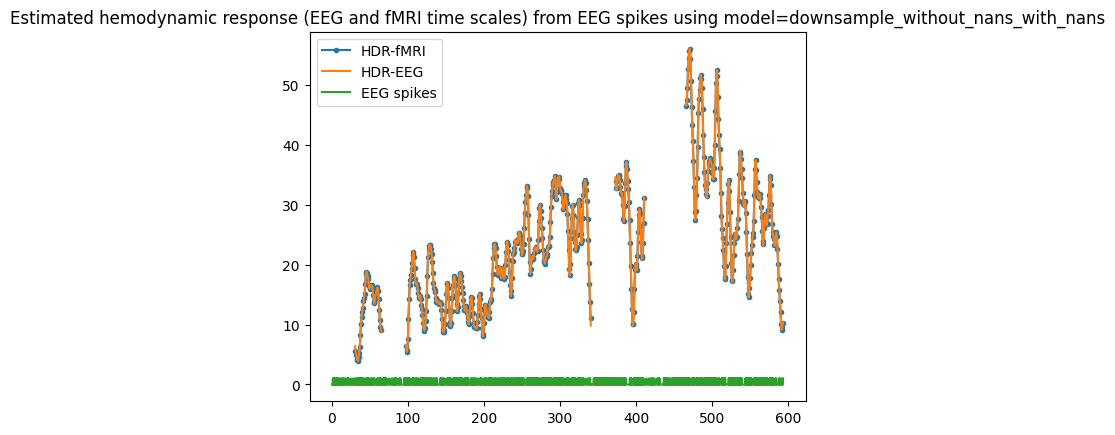

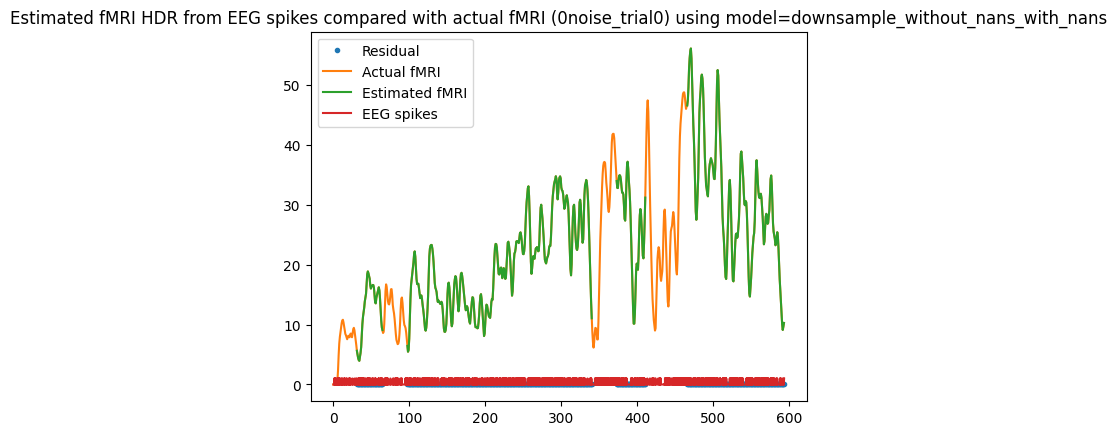

Residual Variance is 0.000000


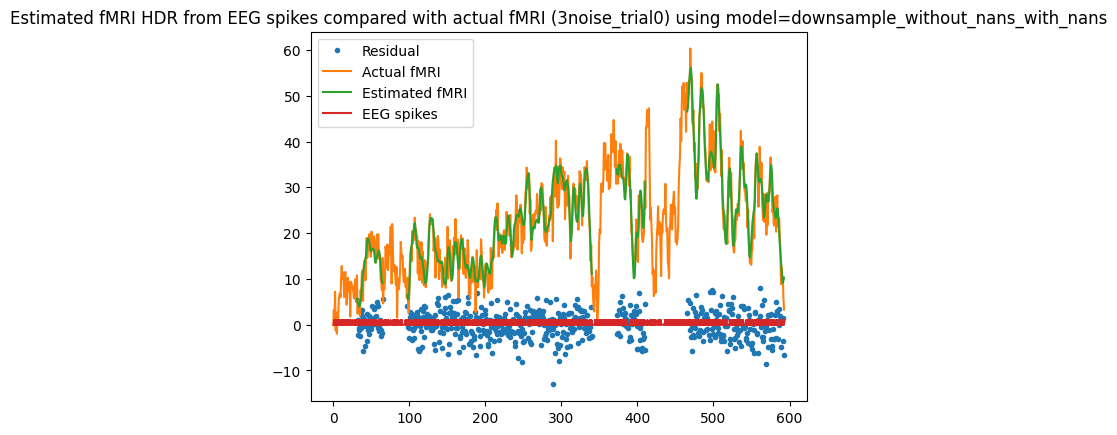

Residual Variance is 9.362000


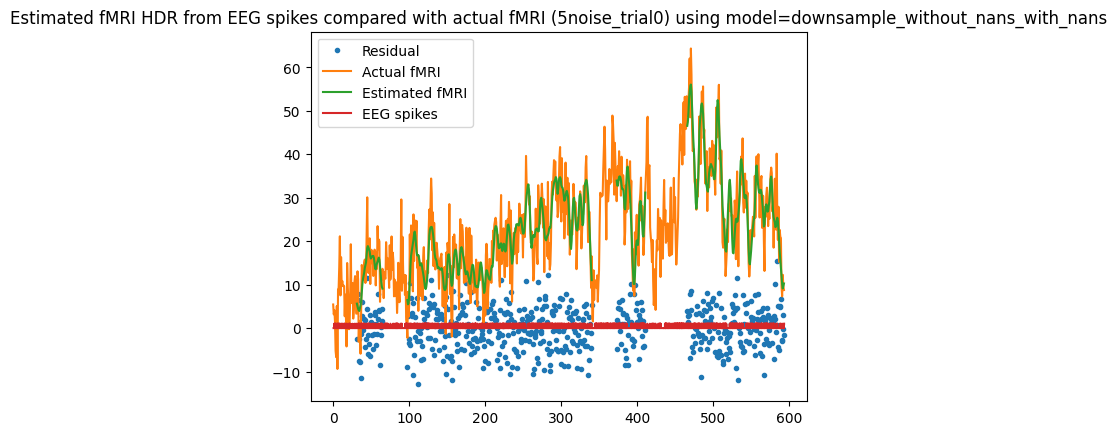

Residual Variance is 23.700543


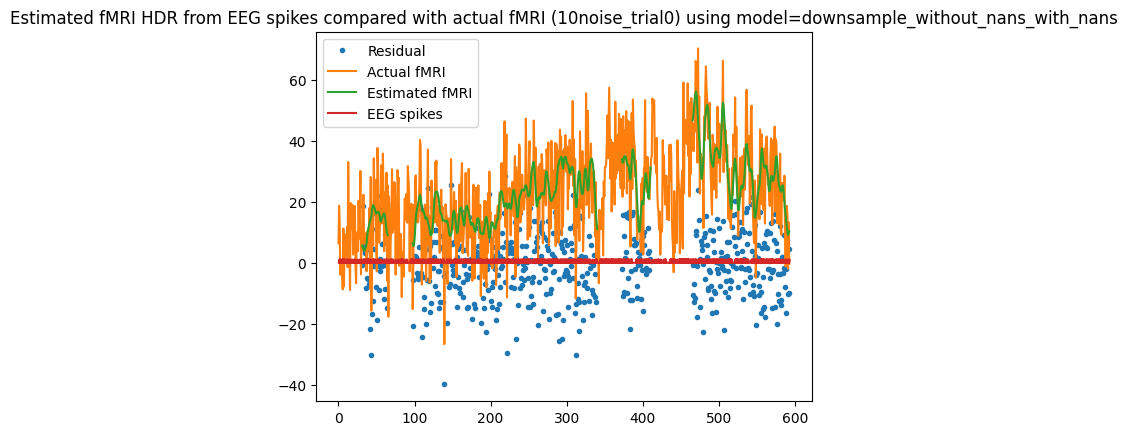

Residual Variance is 116.912086


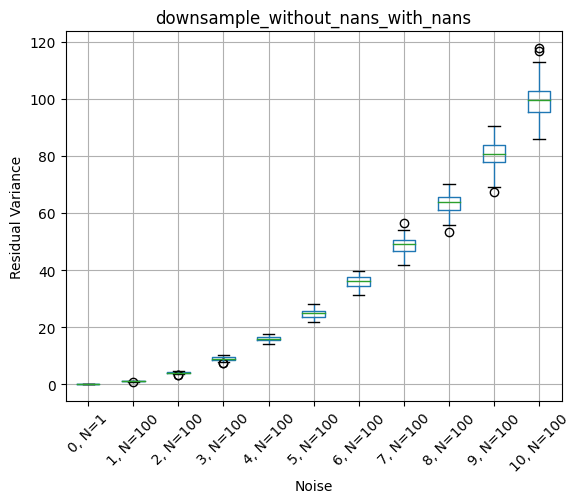

In [7]:
models = build_models(
    model_to_fmri,
    eeg_data_options_for_simulation,
    tr, 
    n_trs_skipped_at_beginning,
    sample_freq,
    hemodynamic_response_window,
    plot
)

# Get in-depth plots for actual delta, tau, alpha
for model_name, model in models.items():
    residual_var = model.score(expected_delta, expected_tau, expected_alpha)
    fmri_names = np.array(model.fmri.voxel_names)
    if (fmri_names == None).any():
        print(f'Residual variance was {residual_var}')
    else:
        noise_levels = np.char.replace(fmri_names, 'perfect', '0noise_trail0')
        noise_levels = np.char.partition(noise_levels, sep='noise')
        res_var_df = pd.DataFrame(zip(noise_levels[:,0].astype(int), residual_var), columns=['Noise', 'res_var'])
        res_var_by_noise = res_var_df.groupby('Noise')
        _, axs = plt.subplots()
        axs.set_title(model_name)
        axs.set_ylabel('Residual Variance')
        axs.set_xlabel('Noise')
        axs = res_var_by_noise.boxplot(column='res_var', subplots=False, rot=45, ax=axs)
        labels = res_var_by_noise.count()
        labels = [f'{noise}, N={n.item()}' for noise, n in zip(labels.index, labels.values)]
        plt.setp(axs, xticklabels=labels)
        plt.show()
    model.plot = False

## Generate/Load the full dataset

In [8]:
# Optional Reuse functionality

df = pd.DataFrame()
descriptions = []

if try_to_reuse:
    matching_files = sorted(glob.glob(f'{filename_substring}*{filename_ext}'))
    filename_to_use = "none"
    if len(matching_files) != 0:
        filename_to_use = input(
            f'Found previously run data. Enter name to reuse or "none" to recalculate.'
            f'\n{matching_files}\nDefault ({matching_files[-1]})\n'
        )
    if filename_to_use.lower() != "none":
        if filename_to_use.strip() == '':
            filename_to_use = matching_files[-1]
        print(f'Loading data from {filename_to_use}...')
        with open(filename_to_use, 'r') as f:
            df = pd.read_csv(f, index_col=0)
        descriptions = generate_descriptions_from_search_df(df, models)


In [9]:
if df.empty:
    if submit_to_cluster:
        raise NotImplemented("Submitting to the cluster is not implemented!")
    print('Generating data!')
    descriptions, df = search_voxels(models, delta, tau, alpha)
    with open(f'{filename_substring}_{datetime.now().strftime("%Y-%m-%d_%H:%M")}{filename_ext}', 'w') as f:
        pd.DataFrame(df).to_csv(f)
    for model_name, description in zip(models.keys(), descriptions):
        with open(f'{model_name}_summary_{filename_substring}_{datetime.now().strftime("%Y-%m-%d_%H:%M")}{filename_ext}', 'w') as f:
            pd.DataFrame(description).transpose().to_csv(f)

df

Generating data!
Scoring delta=1.0
Scoring delta=1.05
Scoring delta=1.1
Scoring delta=1.1500000000000001
Scoring delta=1.2000000000000002
Scoring delta=1.2500000000000002
Scoring delta=1.3000000000000003
Scoring delta=1.3500000000000003
Scoring delta=1.4000000000000004
Scoring delta=1.4500000000000004
Scoring delta=1.5000000000000004
Scoring delta=1.5500000000000005
Scoring delta=1.6000000000000005
Scoring delta=1.6500000000000006
Scoring delta=1.7000000000000006
Scoring delta=1.7500000000000007
Scoring delta=1.8000000000000007
Scoring delta=1.8500000000000008
Scoring delta=1.9000000000000008
Scoring delta=1.9500000000000008
Scoring delta=2.000000000000001
Scoring delta=2.0500000000000007
Scoring delta=2.100000000000001
Scoring delta=2.1500000000000012
Scoring delta=2.200000000000001
Scoring delta=2.250000000000001
Scoring delta=2.300000000000001
Scoring delta=2.3500000000000014
Scoring delta=2.4000000000000012
Scoring delta=2.450000000000001
Scoring delta=2.5000000000000013
Scoring de

delta                 tau               alpha  \
0                     1.0                0.75                1.75   
1                     1.0                0.75                1.75   
2                     1.0                0.75                 1.8   
3                     1.0                0.75                 1.8   
4                     1.0                0.75                1.85   
...                   ...                 ...                 ...   
18937  3.0000000000000018  1.7500000000000009  2.1500000000000004   
18938  3.0000000000000018  1.7500000000000009                 2.2   
18939  3.0000000000000018  1.7500000000000009                 2.2   
18940  3.0000000000000018  1.7500000000000009  2.2500000000000004   
18941  3.0000000000000018  1.7500000000000009  2.2500000000000004   

                                 model_name        0noise_trial0  \
0      downsample_without_nans_without_nans     91.5117829267727   
1         downsample_without_nans_with_nans    81.06757679001892   
2      downsample_without_nans_without_nans    90.83620157239758   
3         downsample_without_nans_with_nans    80.53045099331717   
4      downsample_without_nans_without_nans    90.14674285435309   
...                                     ...                  ...   
18937     downsample_without_nans_with_nans  0.24369168446865855   
18938  downsample_without_nans_without_nans   0.4736439297835514   
18939     downsample_without_nans_with_nans   0.4261543315720019   
18940  downsample_without_nans_without_nans   0.7291949589231067   
18941     downsample_without_nans_with_nans   0.6548535808855585   

            1noise_trial0       2noise_trial0       3noise_trial0  \
0       91.38098414680582   96.31759660782721  100.74238035003192   
1       80.64942813773543   84.29669845232839    90.1520970970229   
2       90.72313070912752   95.62103894584254  100.03121940405485   
3       80.13726976330591   83.75435778063438   89.57695818813448   
4       90.05143078334746   94.91025882726416   99.30671535921205   
...                   ...                 ...                 ...   
18937  1.2410194750596892    4.13848146876212   9.557743762793022   
18938  1.5005713787057737   4.579862071328122   9.659967046461713   
18939  1.4227304415643547   4.322443304878888   9.717445955782658   
18940  1.7623486761338039   4.870378868368199   9.891150877975125   
18941  1.6504160968045205  4.5508336251044135    9.92045319290888   

            4noise_trial0       5noise_trial0  ...      1noise_trial99  \
0      106.83962495208736  110.67732752120715  ...   91.59124624408253   
1       97.15225794169689  104.01409473348404  ...   81.31907176171812   
2      106.20951848599437  110.02026936197987  ...   90.89982551705923   
3       96.68215462659919  103.48041379319183  ...   80.76329483233656   
4       105.5658884745188  109.34965765787894  ...   90.19476501995368   
...                   ...                 ...  ...                 ...   
18937  15.965758459216028  24.112941924510253  ...  1.3390871048742294   
18938  16.239922701226273   24.69440808036892  ...  1.5370879765528451   
18939   16.18637398473939  24.344473489524052  ...  1.5273862252154171   
18940  16.531399898809603   25.03435833599075  ...  1.7916963087985234   
18941   16.45618642842902   24.61858007034888  ...  1.7603326820121936   

           2noise_trial99      3noise_trial99      4noise_trial99  \
0       93.64687217462784  105.16632600690768  109.36850066489747   
1       84.13369120661325   91.42294883028141  101.03851562337957   
2       92.98928397209033   104.4646199640079  108.69100056816826   
3       83.60868303185295   90.88486858930808  100.48470787424861   
4       92.31836988748583  103.74860844172764   107.9997097126852   
...                   ...                 ...                 ...   
18937  4.6423629596908755   8.624347749366787   16.11808208718079   
18938   4.636583321842372   9.624052644906682  16.028332691554773   
18939   4.833192632284576   8.78363

## No Noise Analysis - downsample without missing data

### Cost

Minimal Cost for Average Cost: noise 0 (downsample_without_nans_without_nans) = 2.144226876921804e-27; at
       delta   tau  alpha
18930    3.0  1.75    2.0


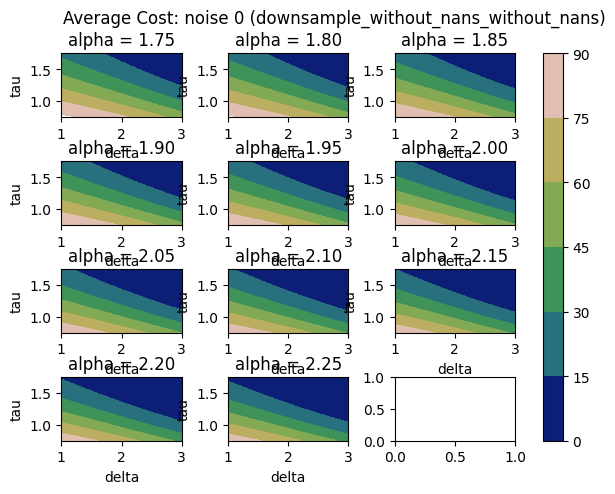

delta   tau  alpha  \
0        1.0  0.75   1.75   
2        1.0  0.75   1.80   
4        1.0  0.75   1.85   
6        1.0  0.75   1.90   
8        1.0  0.75   1.95   
...      ...   ...    ...   
18932    3.0  1.75   2.05   
18934    3.0  1.75   2.10   
18936    3.0  1.75   2.15   
18938    3.0  1.75   2.20   
18940    3.0  1.75   2.25   

       Average Cost: noise 0 (downsample_without_nans_without_nans)  
0                                              91.511783             
2                                              90.836202             
4                                              90.146743             
6                                              89.443419             
8                                              88.726261             
...                                                  ...             
18932                                           0.030912             
18934                                           0.121901             
18936                                           0.270348             
18938                                           0.473644             
18940                                           0.729195             

[9471 rows x 4 columns]

In [10]:
model_name = 'downsample_without_nans_without_nans'
noise = 0
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
columns_for_noise = df_to_plot.columns[columns_to_choose]

average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]

average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
plot_all_search_results_2d(average_df, separate_by='alpha')
average_df


In [11]:
data = []

minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()

for point in zip(*np.where(~np.isnan(minimum_cost_array))):
    row_of_interest = df_to_plot.iloc[point[0]]
    data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha']])
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
pd.DataFrame(data, columns=['delta', 'tau', 'alpha'])

Delta target: 3, Tau target: 1.75, Alpha target: 2


delta   tau  alpha
0    3.0  1.75    2.0

### Local Minima Analysis

In [12]:
delta_unique_values = df_to_plot['delta'].unique()    
tau_unique_values = df_to_plot['tau'].unique()
alpha_unique_values = df_to_plot['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(df_to_plot['delta'].values, new_shape)
tau_pts = np.reshape(df_to_plot['tau'].values, new_shape)
alpha_pts = np.reshape(df_to_plot['alpha'].values, new_shape)

# Find local minima
columns = df_to_plot.columns.drop(['delta', 'tau', 'alpha'])

m = np.reshape(
    df_to_plot[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
noise = 0

columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
for point in local_minima_with_given_noise:
    point_as_list = tuple(point.tolist())
    local_minima.append({
        'noise': noise,
        'iteration': columns[point[-1]].split('trial')[-1],
        'cost': m[point_as_list],
        'delta': delta_pts[point_as_list[:-1]],
        'tau': tau_pts[point_as_list[:-1]],
        'alpha': alpha_pts[point_as_list[:-1]]
    })

local_minima_by_noise = pd.DataFrame(local_minima)
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
local_minima_by_noise

Delta target: 3, Tau target: 1.75, Alpha target: 2


noise iteration          cost  delta   tau  alpha
0      0         0  7.575282e-03   2.85  1.65   2.25
1      0         0  2.295873e-03   2.95  1.70   2.10
2      0         0  2.144227e-27   3.00  1.75   2.00

In [13]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
0                         3.0

#### Local minima at edges

In [14]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [15]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

noise iteration          cost  delta   tau  alpha
2      0         0  2.144227e-27    3.0  1.75    2.0

In [16]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [17]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

noise iteration          cost  delta   tau  alpha
2      0         0  2.144227e-27    3.0  1.75    2.0

In [18]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [19]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration      cost  delta   tau  alpha
0      0         0  0.007575   2.85  1.65   2.25

## No Noise Analysis - downsample with missing data

### Cost

Minimal Cost for Average Cost: noise 0 (downsample_without_nans_with_nans) = 2.898585945307021e-28; at
       delta   tau  alpha
18931    3.0  1.75    2.0


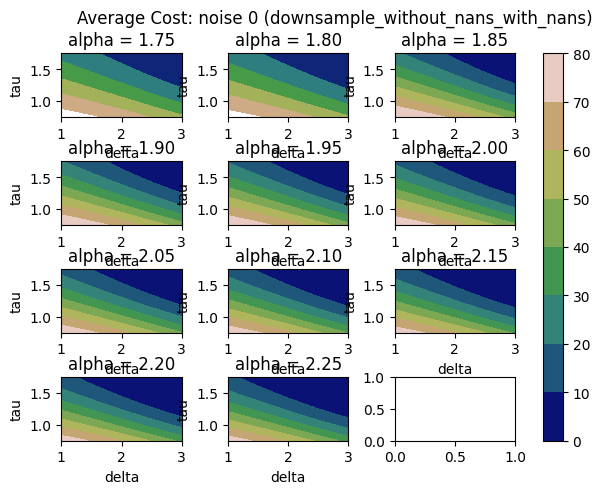

delta   tau  alpha  \
1        1.0  0.75   1.75   
3        1.0  0.75   1.80   
5        1.0  0.75   1.85   
7        1.0  0.75   1.90   
9        1.0  0.75   1.95   
...      ...   ...    ...   
18933    3.0  1.75   2.05   
18935    3.0  1.75   2.10   
18937    3.0  1.75   2.15   
18939    3.0  1.75   2.20   
18941    3.0  1.75   2.25   

       Average Cost: noise 0 (downsample_without_nans_with_nans)  
1                                              81.067577          
3                                              80.530451          
5                                              79.980289          
7                                              79.416994          
9                                              78.840492          
...                                                  ...          
18933                                           0.027965          
18935                                           0.110082          
18937                                           0.243692          
18939                                           0.426154          
18941                                           0.654854          

[9471 rows x 4 columns]

In [20]:
model_name = 'downsample_without_nans_with_nans'
noise = 0
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
columns_for_noise = df_to_plot.columns[columns_to_choose]

average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]

average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
plot_all_search_results_2d(average_df, separate_by='alpha')
average_df


In [21]:
data = []

minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()

for point in zip(*np.where(~np.isnan(minimum_cost_array))):
    row_of_interest = df_to_plot.iloc[point[0]]
    data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha']])
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
pd.DataFrame(data, columns=['delta', 'tau', 'alpha'])

Delta target: 3, Tau target: 1.75, Alpha target: 2


delta   tau  alpha
0    3.0  1.75    2.0

### Local Minima Analysis

In [22]:
delta_unique_values = df_to_plot['delta'].unique()    
tau_unique_values = df_to_plot['tau'].unique()
alpha_unique_values = df_to_plot['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(df_to_plot['delta'].values, new_shape)
tau_pts = np.reshape(df_to_plot['tau'].values, new_shape)
alpha_pts = np.reshape(df_to_plot['alpha'].values, new_shape)

# Find local minima
columns = df_to_plot.columns.drop(['delta', 'tau', 'alpha'])

m = np.reshape(
    df_to_plot[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
noise = 0

columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
for point in local_minima_with_given_noise:
    point_as_list = tuple(point.tolist())
    local_minima.append({
        'noise': noise,
        'iteration': columns[point[-1]].split('trial')[-1],
        'cost': m[point_as_list],
        'delta': delta_pts[point_as_list[:-1]],
        'tau': tau_pts[point_as_list[:-1]],
        'alpha': alpha_pts[point_as_list[:-1]]
    })

local_minima_by_noise = pd.DataFrame(local_minima)
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
local_minima_by_noise

Delta target: 3, Tau target: 1.75, Alpha target: 2


noise iteration          cost  delta   tau  alpha
0      0         0  7.236230e-03   2.85  1.65   2.25
1      0         0  2.079698e-03   2.95  1.70   2.10
2      0         0  2.898586e-28   3.00  1.75   2.00

In [23]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
0                         3.0

#### Local minima at edges

In [24]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [25]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

noise iteration          cost  delta   tau  alpha
2      0         0  2.898586e-28    3.0  1.75    2.0

In [26]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [27]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

noise iteration          cost  delta   tau  alpha
2      0         0  2.898586e-28    3.0  1.75    2.0

In [28]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [29]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration      cost  delta   tau  alpha
0      0         0  0.007236   2.85  1.65   2.25

## Cost by Noise

### Downsample without Missing Data

Minimal Cost for Average Cost: noise 1 (downsample_without_nans_without_nans) = 0.993588802076972; at
       delta   tau  alpha
18930    3.0  1.75    2.0


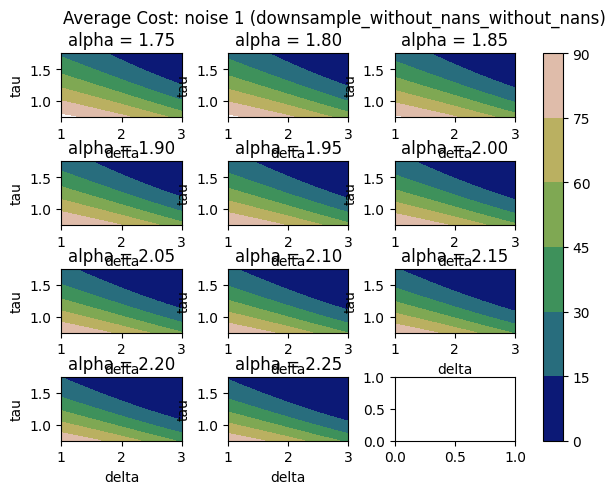

Minimal Cost for Average Cost: noise 2 (downsample_without_nans_without_nans) = 3.986893509492013; at
       delta   tau  alpha
18930    3.0  1.75    2.0


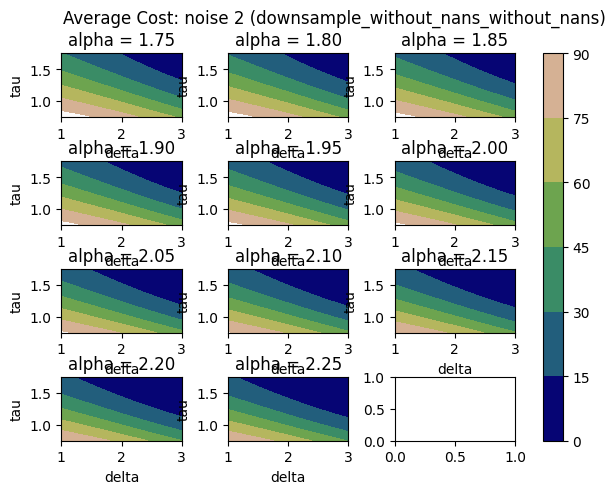

Minimal Cost for Average Cost: noise 3 (downsample_without_nans_without_nans) = 9.002319536815923; at
       delta   tau  alpha
18930    3.0  1.75    2.0


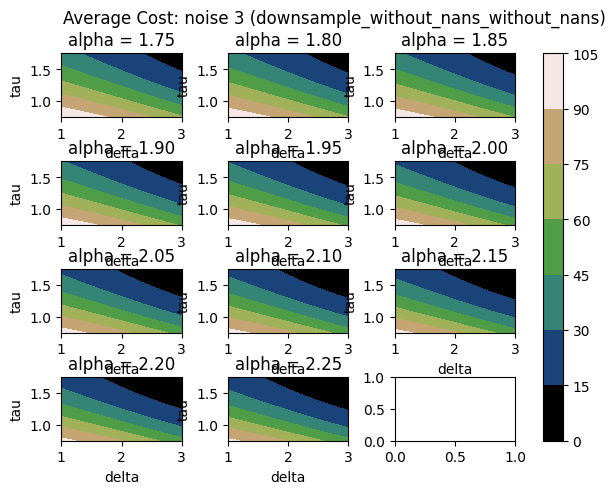

Minimal Cost for Average Cost: noise 4 (downsample_without_nans_without_nans) = 15.98559567297159; at
       delta   tau  alpha
17510   2.85  1.65   2.25


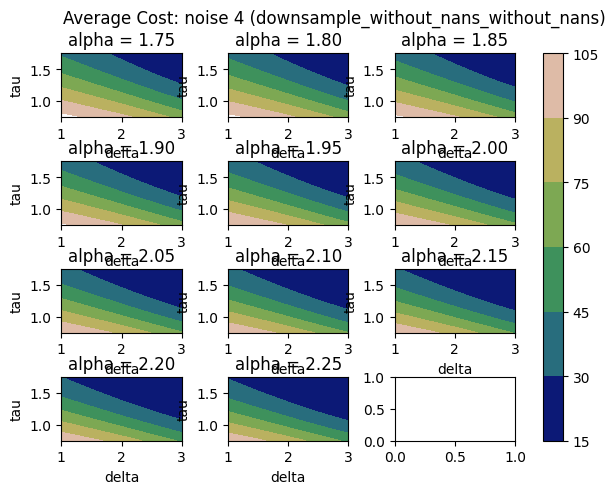

Minimal Cost for Average Cost: noise 5 (downsample_without_nans_without_nans) = 24.915624153295415; at
       delta   tau  alpha
18930    3.0  1.75    2.0


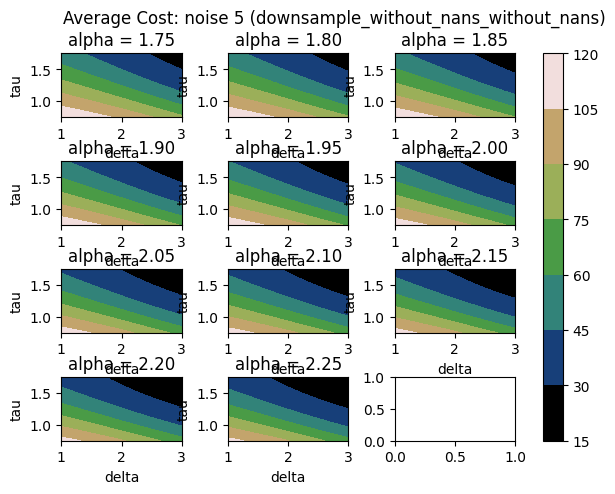

Minimal Cost for Average Cost: noise 6 (downsample_without_nans_without_nans) = 36.03105108570344; at
       delta   tau  alpha
18930    3.0  1.75    2.0


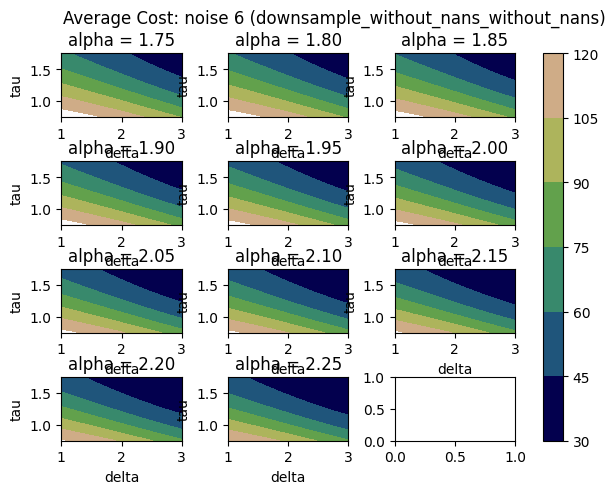

Minimal Cost for Average Cost: noise 7 (downsample_without_nans_without_nans) = 48.9190490379946; at
       delta  tau  alpha
18450   2.95  1.7    2.1


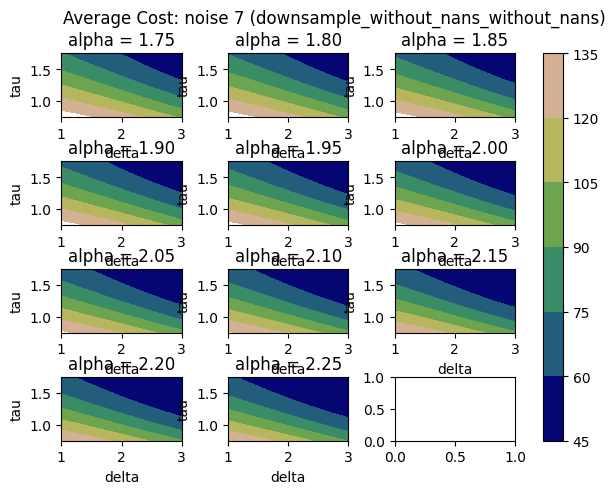

Minimal Cost for Average Cost: noise 8 (downsample_without_nans_without_nans) = 63.60758473474749; at
       delta   tau  alpha
18930    3.0  1.75    2.0


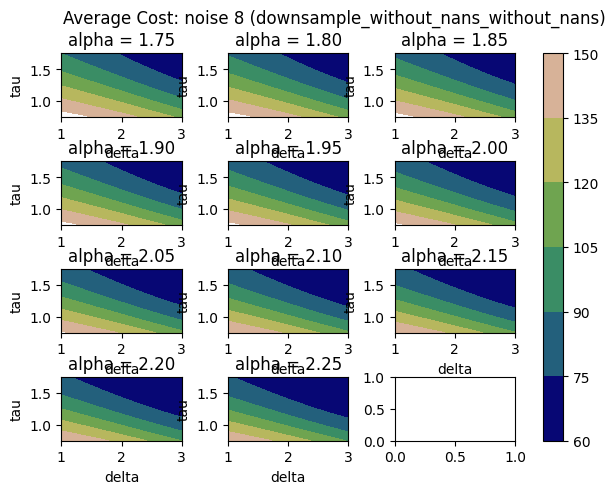

Minimal Cost for Average Cost: noise 9 (downsample_without_nans_without_nans) = 80.70328621546273; at
       delta  tau  alpha
18450   2.95  1.7    2.1


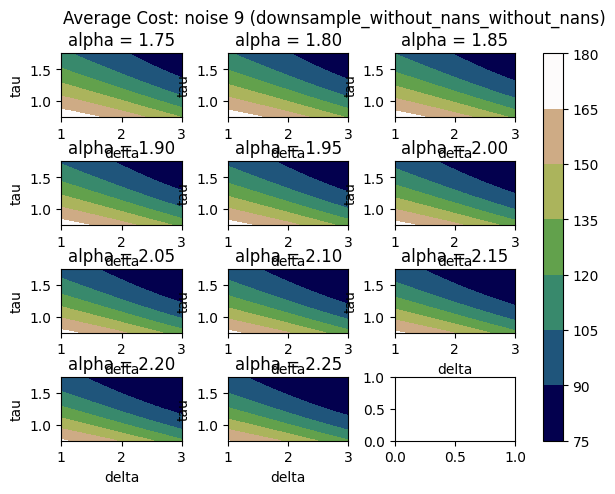

Minimal Cost for Average Cost: noise 10 (downsample_without_nans_without_nans) = 99.6893975439459; at
       delta  tau  alpha
17990    2.9  1.7   2.15


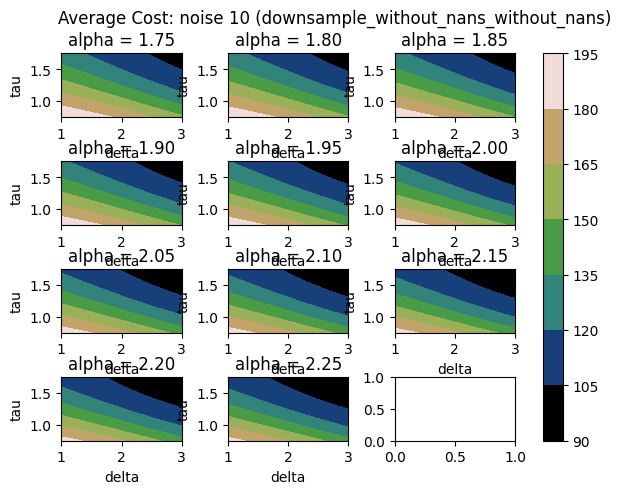

In [30]:
model_name = 'downsample_without_nans_without_nans'
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]

    average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]
    average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
    plot_all_search_results_2d(average_df, separate_by='alpha')

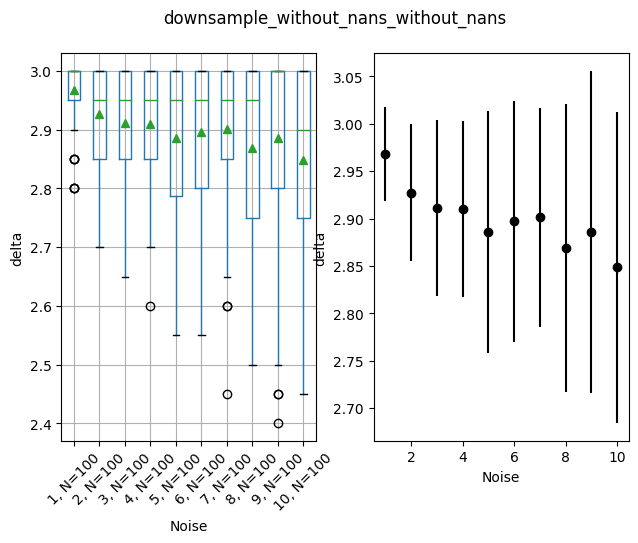

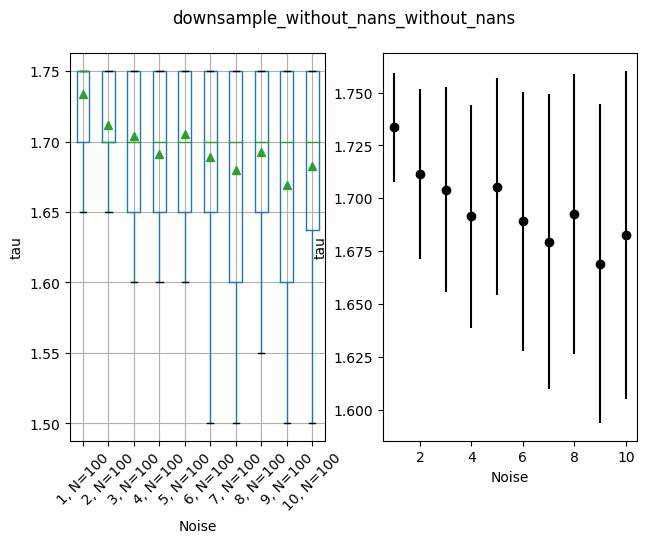

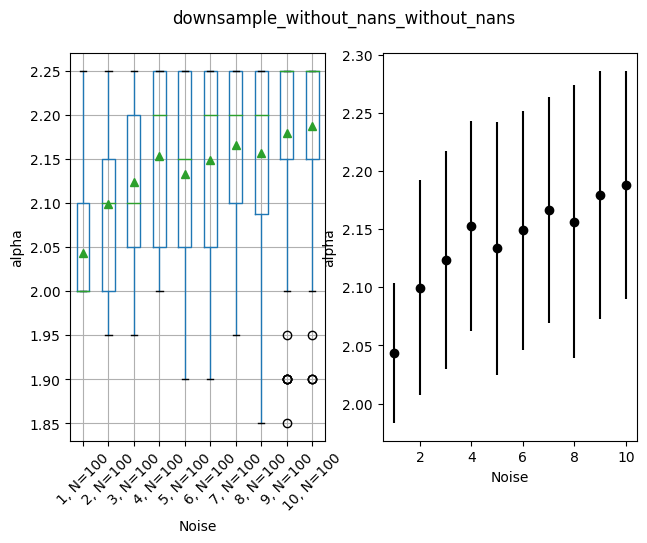

In [31]:
data = []
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]
    minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
    minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()
    
    for point in zip(*np.where(~np.isnan(minimum_cost_array))):
        row_of_interest = df_to_plot.iloc[point[0]]
        data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha'], noise])

chosen_points = pd.DataFrame(data, columns=['delta', 'tau', 'alpha', 'noise']).groupby('noise')

for variable in ['delta', 'tau', 'alpha']:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(model_name)
    fig.tight_layout()
    axs[0].set_ylabel(variable)
    axs[0].set_xlabel('Noise')
    axs[0] = chosen_points.boxplot(subplots=False, column=variable, rot=45, ax=axs[0], showmeans=True)
    axs[1].set_ylabel(variable)
    axs[1].set_xlabel('Noise')
    axs[1].errorbar(noise_range, chosen_points.mean()[variable], chosen_points.std()[variable], fmt='ok')
    labels = chosen_points.count()
    labels = [f'{noise}, N={n[0].item()}' for noise, n in zip(labels.index, labels.values)]
    plt.setp(axs[0], xticklabels=labels)
    plt.show()

### Downsample with Missing Data

Minimal Cost for Average Cost: noise 1 (downsample_without_nans_with_nans) = 0.9934117167220181; at
       delta   tau  alpha
18931    3.0  1.75    2.0


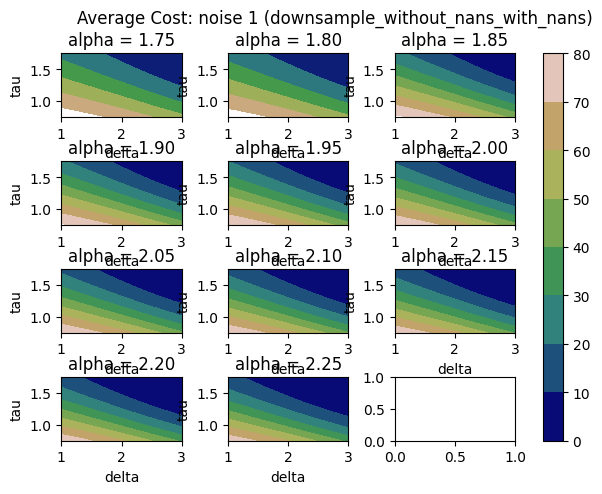

Minimal Cost for Average Cost: noise 2 (downsample_without_nans_with_nans) = 3.9968593530792043; at
       delta   tau  alpha
18931    3.0  1.75    2.0


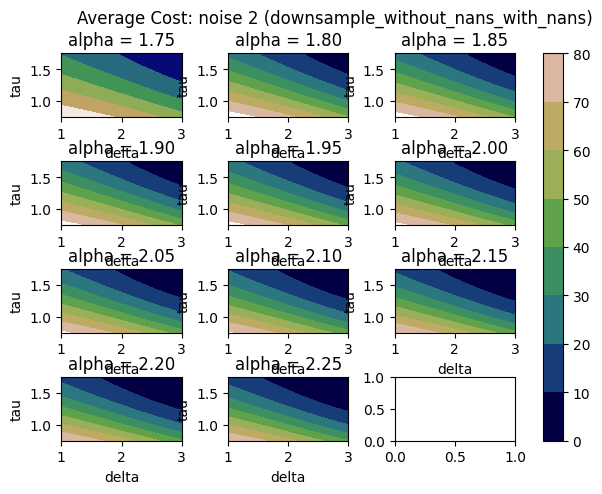

Minimal Cost for Average Cost: noise 3 (downsample_without_nans_with_nans) = 8.989932127199694; at
       delta   tau  alpha
18931    3.0  1.75    2.0


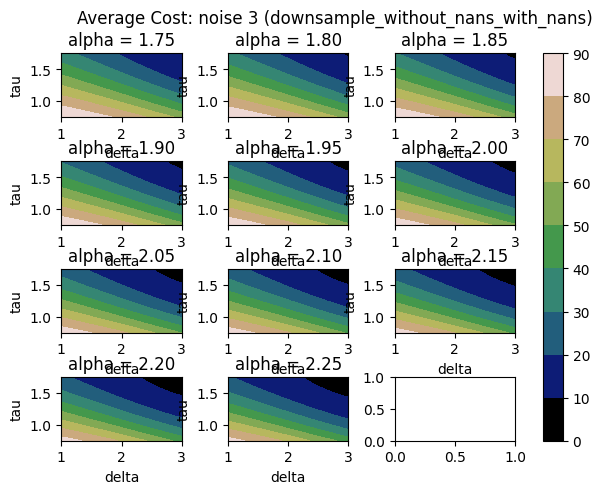

Minimal Cost for Average Cost: noise 4 (downsample_without_nans_with_nans) = 15.999318369383023; at
       delta  tau  alpha
18451   2.95  1.7    2.1


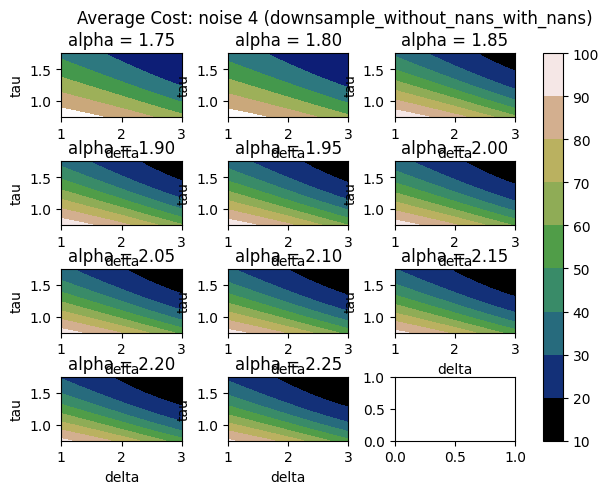

Minimal Cost for Average Cost: noise 5 (downsample_without_nans_with_nans) = 24.79673074581436; at
       delta   tau  alpha
18931    3.0  1.75    2.0


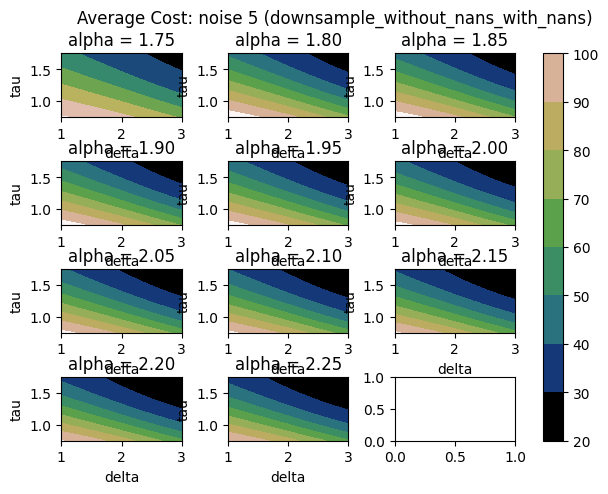

Minimal Cost for Average Cost: noise 6 (downsample_without_nans_with_nans) = 35.97547254257258; at
       delta   tau  alpha
18931    3.0  1.75    2.0


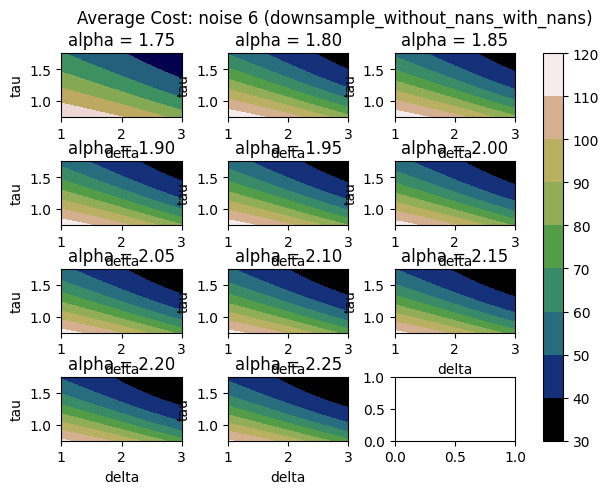

Minimal Cost for Average Cost: noise 7 (downsample_without_nans_with_nans) = 48.79990857995858; at
       delta  tau  alpha
18451   2.95  1.7    2.1


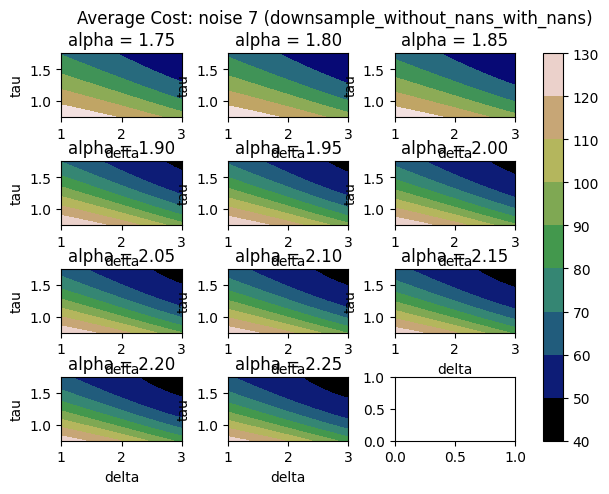

Minimal Cost for Average Cost: noise 8 (downsample_without_nans_with_nans) = 63.47190630918508; at
       delta   tau  alpha
18931    3.0  1.75    2.0


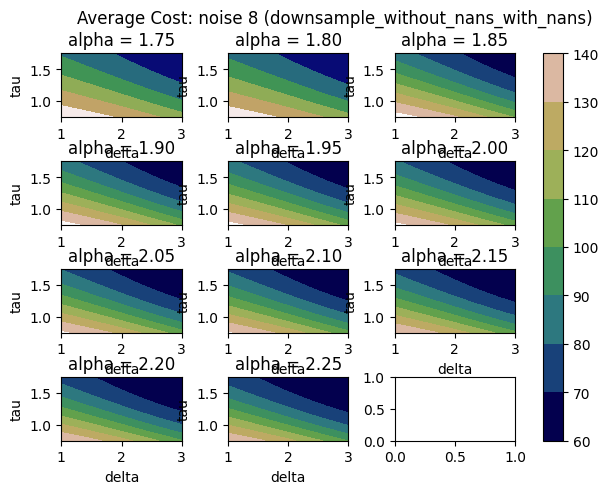

Minimal Cost for Average Cost: noise 9 (downsample_without_nans_with_nans) = 80.64205399928973; at
       delta  tau  alpha
18911    3.0  1.7   2.05


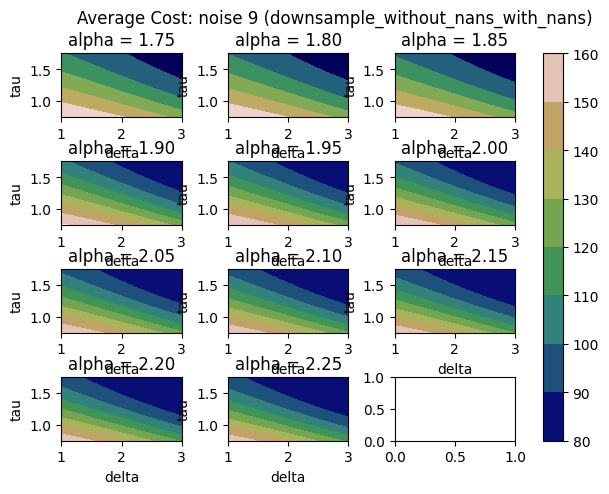

Minimal Cost for Average Cost: noise 10 (downsample_without_nans_with_nans) = 99.4596471515269; at
       delta  tau  alpha
17529   2.85  1.7   2.15


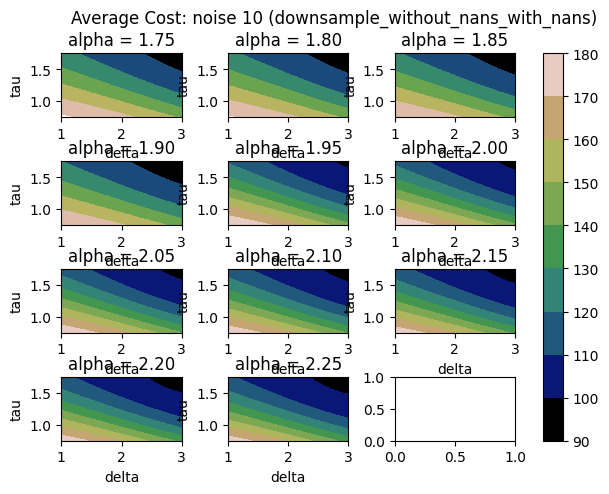

In [32]:
model_name = 'downsample_without_nans_with_nans'
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]

    average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]
    average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
    plot_all_search_results_2d(average_df, separate_by='alpha')


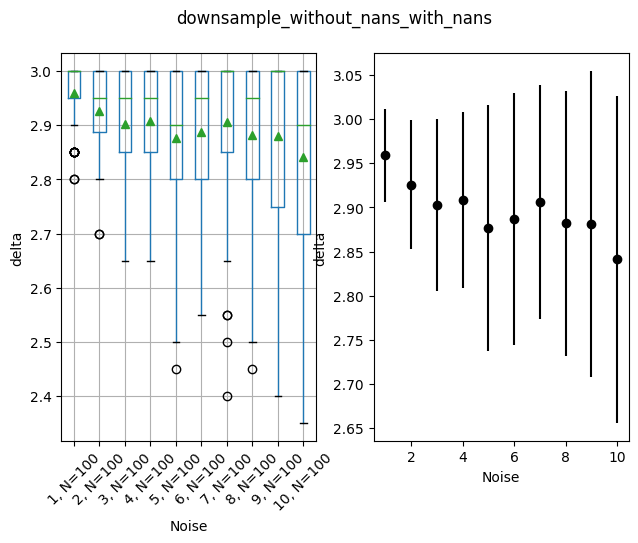

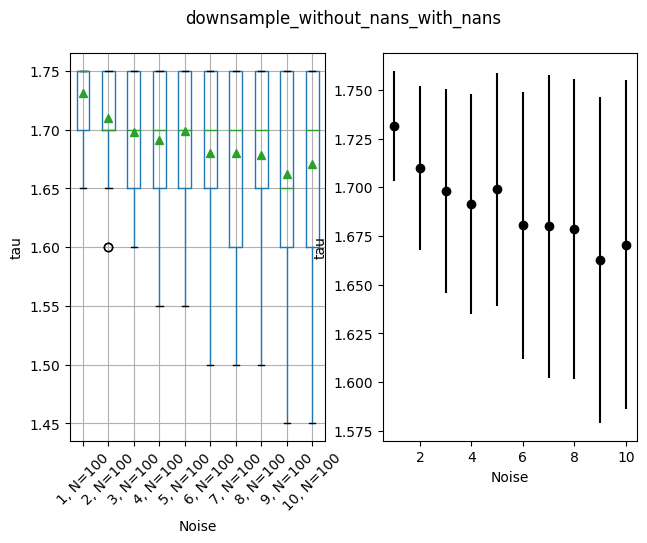

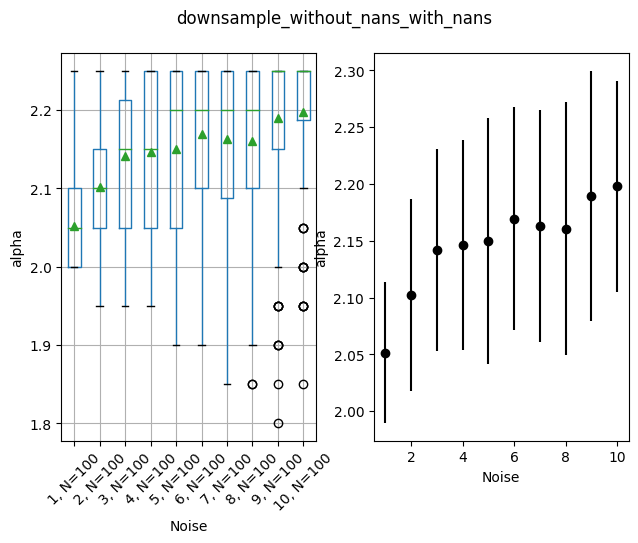

In [33]:
data = []
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]
    minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
    minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()
    
    for point in zip(*np.where(~np.isnan(minimum_cost_array))):
        row_of_interest = df_to_plot.iloc[point[0]]
        data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha'], noise])

chosen_points = pd.DataFrame(data, columns=['delta', 'tau', 'alpha', 'noise']).groupby('noise')

for variable in ['delta', 'tau', 'alpha']:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(model_name)
    fig.tight_layout()
    axs[0].set_ylabel(variable)
    axs[0].set_xlabel('Noise')
    axs[0] = chosen_points.boxplot(subplots=False, column=variable, rot=45, ax=axs[0], showmeans=True)
    axs[1].set_ylabel(variable)
    axs[1].set_xlabel('Noise')
    axs[1].errorbar(noise_range, chosen_points.mean()[variable], chosen_points.std()[variable], fmt='ok')
    labels = chosen_points.count()
    labels = [f'{noise}, N={n[0].item()}' for noise, n in zip(labels.index, labels.values)]
    plt.setp(axs[0], xticklabels=labels)
    plt.show()

## Local Minima Analysis

### Downsample without missing data

In [34]:
model = df['model_name'].unique()[0]
print(f"For Model '{model}'")
portion_df = df[df['model_name'] == model].drop(columns='model_name')
delta_unique_values = portion_df['delta'].unique()    
tau_unique_values = portion_df['tau'].unique()
alpha_unique_values = portion_df['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(portion_df['delta'].values, new_shape)
tau_pts = np.reshape(portion_df['tau'].values, new_shape)
alpha_pts = np.reshape(portion_df['alpha'].values, new_shape)

For Model 'downsample_without_nans_without_nans'


In [35]:
# Find local minima
columns = portion_df.columns.drop(['delta', 'tau', 'alpha'])
     
m = np.reshape(
    portion_df[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

In [36]:
local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
for noise in noise_range:
    columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
    local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
    for point in local_minima_with_given_noise:
        point_as_list = tuple(point.tolist())
        local_minima.append({
            'noise': noise,
            'iteration': columns[point[-1]].split('trial')[-1],
            'cost': m[point_as_list],
            'delta': delta_pts[point_as_list[:-1]],
            'tau': tau_pts[point_as_list[:-1]],
            'alpha': alpha_pts[point_as_list[:-1]]
        })

local_minima_by_noise = pd.DataFrame(local_minima)
local_minima_by_noise


noise iteration        cost               delta                 tau  \
0         1         7    0.963464  2.8000000000000016  1.6500000000000008   
1         1        18    0.976310  2.8000000000000016  1.6500000000000008   
2         1        35    1.014710  2.8000000000000016  1.6500000000000008   
3         1        42    0.964118  2.8000000000000016  1.6500000000000008   
4         1        49    0.971804  2.8000000000000016  1.6500000000000008   
...     ...       ...         ...                 ...                 ...   
1930     10        24   98.229463  3.0000000000000018  1.7500000000000009   
1931     10         8  102.453713  3.0000000000000018  1.7500000000000009   
1932     10        15   98.183841  3.0000000000000018  1.7500000000000009   
1933     10        11  100.331963  3.0000000000000018  1.7500000000000009   
1934     10        37  101.416592  3.0000000000000018  1.7500000000000009   

                   alpha  
0     2.2500000000000004  
1     2.2500000000000004  
2     2.2500000000000004  
3     2.2500000000000004  
4     2.2500000000000004  
...                  ...  
1930  2.0500000000000003  
1931  2.1000000000000005  
1932  2.1000000000000005  
1933                 2.2  
1934  2.2500000000000004  

[1935 rows x 6 columns]

In [37]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').describe()

Number of Local Minima                                         
                       count  mean       std  min  25%  50%  75%  max
noise                                                                
1                      100.0  2.91  0.604612  2.0  3.0  3.0  3.0  4.0
2                      100.0  2.57  0.755518  1.0  2.0  3.0  3.0  4.0
3                      100.0  2.14  0.804281  1.0  2.0  2.0  3.0  4.0
4                      100.0  2.00  0.804030  1.0  1.0  2.0  2.0  4.0
5                      100.0  1.87  0.860526  1.0  1.0  2.0  2.0  4.0
6                      100.0  1.68  0.789834  1.0  1.0  1.5  2.0  4.0
7                      100.0  1.70  0.797724  1.0  1.0  2.0  2.0  4.0
8                      100.0  1.67  0.841535  1.0  1.0  1.0  2.0  4.0
9                      100.0  1.43  0.685418  1.0  1.0  1.0  2.0  4.0
10                     100.0  1.38  0.647918  1.0  1.0  1.0  2.0  4.0

#### Local minima at edges

In [38]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [39]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

noise iteration        cost               delta                 tau  \
209       1         2    1.003989  3.0000000000000018  1.7000000000000008   
210       1        35    1.000696  3.0000000000000018  1.7000000000000008   
211       1        44    0.999035  3.0000000000000018  1.7000000000000008   
212       1        81    1.094246  3.0000000000000018  1.7000000000000008   
213       1         0    0.996118  3.0000000000000018  1.7500000000000009   
...     ...       ...         ...                 ...                 ...   
1930     10        24   98.229463  3.0000000000000018  1.7500000000000009   
1931     10         8  102.453713  3.0000000000000018  1.7500000000000009   
1932     10        15   98.183841  3.0000000000000018  1.7500000000000009   
1933     10        11  100.331963  3.0000000000000018  1.7500000000000009   
1934     10        37  101.416592  3.0000000000000018  1.7500000000000009   

                   alpha  
209   2.0500000000000003  
210   2.0500000000000003  
211   2.0500000000000003  
212   2.0500000000000003  
213                  2.0  
...                  ...  
1930  2.0500000000000003  
1931  2.1000000000000005  
1932  2.1000000000000005  
1933                 2.2  
1934  2.2500000000000004  

[638 rows x 6 columns]

In [40]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [41]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

noise iteration        cost               delta                 tau  \
129       1         3    0.991742  2.9000000000000017  1.7500000000000009   
130       1        13    1.049775  2.9000000000000017  1.7500000000000009   
131       1        20    0.966659  2.9000000000000017  1.7500000000000009   
132       1        29    0.994246  2.9000000000000017  1.7500000000000009   
133       1        43    1.020965  2.9000000000000017  1.7500000000000009   
...     ...       ...         ...                 ...                 ...   
1930     10        24   98.229463  3.0000000000000018  1.7500000000000009   
1931     10         8  102.453713  3.0000000000000018  1.7500000000000009   
1932     10        15   98.183841  3.0000000000000018  1.7500000000000009   
1933     10        11  100.331963  3.0000000000000018  1.7500000000000009   
1934     10        37  101.416592  3.0000000000000018  1.7500000000000009   

                   alpha  
129   2.0500000000000003  
130   2.0500000000000003  
131   2.0500000000000003  
132   2.0500000000000003  
133   2.0500000000000003  
...                  ...  
1930  2.0500000000000003  
1931  2.1000000000000005  
1932  2.1000000000000005  
1933                 2.2  
1934  2.2500000000000004  

[671 rows x 6 columns]

In [42]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [43]:
alpha_min.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

Empty DataFrame
Columns: [(delta, count), (delta, unique), (delta, top), (delta, freq), (tau, count), (tau, unique), (tau, top), (tau, freq)]
Index: []

In [44]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration        cost               delta                 tau  \
0         1         7    0.963464  2.8000000000000016  1.6500000000000008   
1         1        18    0.976310  2.8000000000000016  1.6500000000000008   
2         1        35    1.014710  2.8000000000000016  1.6500000000000008   
3         1        42    0.964118  2.8000000000000016  1.6500000000000008   
4         1        49    0.971804  2.8000000000000016  1.6500000000000008   
...     ...       ...         ...                 ...                 ...   
1907     10        95  107.084769  3.0000000000000018  1.6000000000000008   
1916     10         2  104.207686  3.0000000000000018  1.6500000000000008   
1917     10        78   91.105585  3.0000000000000018  1.6500000000000008   
1920     10        21  101.939774  3.0000000000000018  1.7000000000000008   
1934     10        37  101.416592  3.0000000000000018  1.7500000000000009   

                   alpha  
0     2.2500000000000004  
1     2.2500000000000004  
2     2.2500000000000004  
3     2.2500000000000004  
4     2.2500000000000004  
...                  ...  
1907  2.2500000000000004  
1916  2.2500000000000004  
1917  2.2500000000000004  
1920  2.2500000000000004  
1934  2.2500000000000004  

[538 rows x 6 columns]

In [45]:
alpha_max.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        52      2  2.8500000000000014   36    52      1  1.6500000000000008   
10       67     13  3.0000000000000018   18    67      6  1.7500000000000009   
2        41      6  2.8000000000000016   19    41      3  1.6500000000000008   
3        38      8  2.8500000000000014   12    38      4  1.6500000000000008   
4        53      9  2.8000000000000016   16    53      4  1.6500000000000008   
5        51     10  2.8500000000000014   11    51      4  1.6500000000000008   
6        52     10  3.0000000000000018    9    52      6  1.6500000000000008   
7        57     10  3.0000000000000018   17    57      6  1.6000000000000008   
8        59     12  3.0000000000000018   16    59      5  1.6000000000000008   
9        68     13  3.0000000000000018   30    68      6  1.6500000000000008   

            
      freq  
noise       
1       52  
10      26  
2       35  
3       24  
4       27  
5       21  
6       20  
7       15  
8       16  
9       17

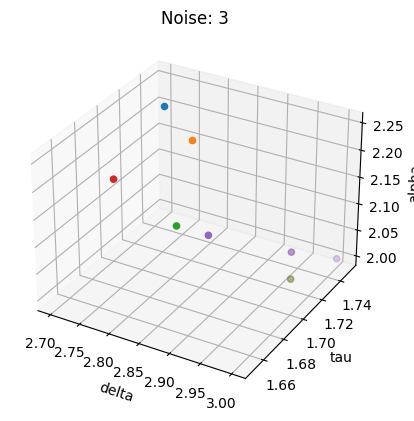

In [46]:
noise = 3
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

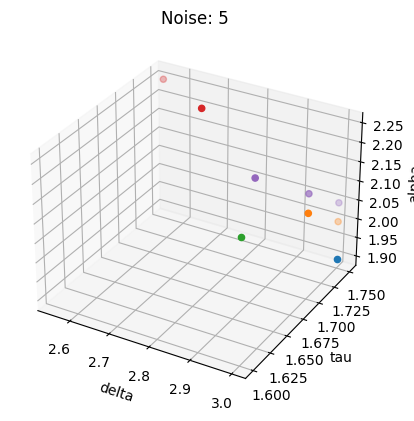

In [47]:
noise = 5
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

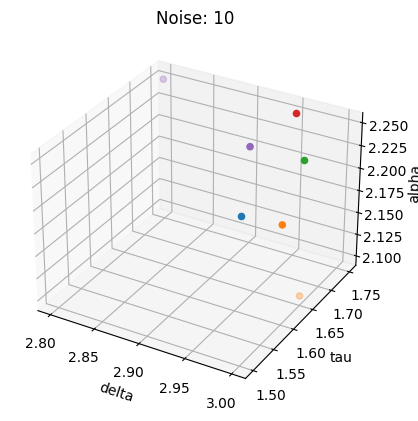

In [48]:
noise = 10
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

### Downsample with missing data

In [49]:
model = df['model_name'].unique()[1]
print(f"For Model '{model}'")
portion_df = df[df['model_name'] == model].drop(columns='model_name')
delta_unique_values = portion_df['delta'].unique()    
tau_unique_values = portion_df['tau'].unique()
alpha_unique_values = portion_df['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(portion_df['delta'].values, new_shape)
tau_pts = np.reshape(portion_df['tau'].values, new_shape)
alpha_pts = np.reshape(portion_df['alpha'].values, new_shape)

For Model 'downsample_without_nans_with_nans'


In [50]:
# Find local minima
columns = portion_df.columns.drop(['delta', 'tau', 'alpha'])
     
m = np.reshape(
    portion_df[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

In [51]:
local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
for noise in noise_range:
    columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
    local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
    for point in local_minima_with_given_noise:
        point_as_list = tuple(point.tolist())
        local_minima.append({
            'noise': noise,
            'iteration': columns[point[-1]].split('trial')[-1],
            'cost': m[point_as_list],
            'delta': delta_pts[point_as_list[:-1]],
            'tau': tau_pts[point_as_list[:-1]],
            'alpha': alpha_pts[point_as_list[:-1]]
        })

local_minima_by_noise = pd.DataFrame(local_minima)
local_minima_by_noise


noise iteration        cost               delta                 tau  \
0         1         7    0.979703  2.8000000000000016  1.6500000000000008   
1         1        18    0.964988  2.8000000000000016  1.6500000000000008   
2         1        28    0.868483  2.8000000000000016  1.6500000000000008   
3         1        31    1.147938  2.8000000000000016  1.6500000000000008   
4         1        41    0.970787  2.8000000000000016  1.6500000000000008   
...     ...       ...         ...                 ...                 ...   
1778     10         7   92.218991  3.0000000000000018  1.7500000000000009   
1779     10         8  104.608062  3.0000000000000018  1.7500000000000009   
1780     10        12   88.960313  3.0000000000000018  1.7500000000000009   
1781     10        37  103.654753  3.0000000000000018  1.7500000000000009   
1782     10        82  100.257055  3.0000000000000018  1.7500000000000009   

                   alpha  
0     2.2500000000000004  
1     2.2500000000000004  
2     2.2500000000000004  
3     2.2500000000000004  
4     2.2500000000000004  
...                  ...  
1778  2.1000000000000005  
1779  2.2500000000000004  
1780  2.2500000000000004  
1781  2.2500000000000004  
1782  2.2500000000000004  

[1783 rows x 6 columns]

In [52]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').describe()

Number of Local Minima                                         
                       count  mean       std  min  25%  50%  75%  max
noise                                                                
1                      100.0  2.60  0.603023  1.0  2.0  3.0  3.0  4.0
2                      100.0  2.39  0.737111  1.0  2.0  2.0  3.0  4.0
3                      100.0  2.11  0.815197  1.0  2.0  2.0  3.0  4.0
4                      100.0  1.84  0.774857  1.0  1.0  2.0  2.0  4.0
5                      100.0  1.68  0.815011  1.0  1.0  1.0  2.0  4.0
6                      100.0  1.44  0.656283  1.0  1.0  1.0  2.0  4.0
7                      100.0  1.48  0.745085  1.0  1.0  1.0  2.0  4.0
8                      100.0  1.62  0.873632  1.0  1.0  1.0  2.0  4.0
9                      100.0  1.34  0.606697  1.0  1.0  1.0  2.0  4.0
10                     100.0  1.33  0.652191  1.0  1.0  1.0  1.0  4.0

#### Local minima at edges

In [53]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [54]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

noise iteration        cost               delta                 tau  \
192       1        35    1.022945  3.0000000000000018  1.7000000000000008   
193       1        44    1.004770  3.0000000000000018  1.7000000000000008   
194       1        56    0.975388  3.0000000000000018  1.7000000000000008   
195       1        87    1.009719  3.0000000000000018  1.7000000000000008   
196       1        94    0.942146  3.0000000000000018  1.7000000000000008   
...     ...       ...         ...                 ...                 ...   
1778     10         7   92.218991  3.0000000000000018  1.7500000000000009   
1779     10         8  104.608062  3.0000000000000018  1.7500000000000009   
1780     10        12   88.960313  3.0000000000000018  1.7500000000000009   
1781     10        37  103.654753  3.0000000000000018  1.7500000000000009   
1782     10        82  100.257055  3.0000000000000018  1.7500000000000009   

                   alpha  
192   2.0500000000000003  
193   2.0500000000000003  
194   2.0500000000000003  
195   2.0500000000000003  
196   2.0500000000000003  
...                  ...  
1778  2.1000000000000005  
1779  2.2500000000000004  
1780  2.2500000000000004  
1781  2.2500000000000004  
1782  2.2500000000000004  

[597 rows x 6 columns]

In [55]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [56]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

noise iteration        cost               delta                 tau  \
61        1        20    0.965615  2.8500000000000014  1.7500000000000009   
62        1        88    1.056792  2.8500000000000014  1.7500000000000009   
114       1         3    1.037172  2.9000000000000017  1.7500000000000009   
115       1         4    0.989905  2.9000000000000017  1.7500000000000009   
116       1        11    0.959084  2.9000000000000017  1.7500000000000009   
...     ...       ...         ...                 ...                 ...   
1778     10         7   92.218991  3.0000000000000018  1.7500000000000009   
1779     10         8  104.608062  3.0000000000000018  1.7500000000000009   
1780     10        12   88.960313  3.0000000000000018  1.7500000000000009   
1781     10        37  103.654753  3.0000000000000018  1.7500000000000009   
1782     10        82  100.257055  3.0000000000000018  1.7500000000000009   

                   alpha  
61    2.1000000000000005  
62    2.1000000000000005  
114   2.0500000000000003  
115   2.0500000000000003  
116   2.0500000000000003  
...                  ...  
1778  2.1000000000000005  
1779  2.2500000000000004  
1780  2.2500000000000004  
1781  2.2500000000000004  
1782  2.2500000000000004  

[649 rows x 6 columns]

In [57]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [58]:
alpha_min.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

Empty DataFrame
Columns: [(delta, count), (delta, unique), (delta, top), (delta, freq), (tau, count), (tau, unique), (tau, top), (tau, freq)]
Index: []

In [59]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration        cost               delta                 tau  \
0         1         7    0.979703  2.8000000000000016  1.6500000000000008   
1         1        18    0.964988  2.8000000000000016  1.6500000000000008   
2         1        28    0.868483  2.8000000000000016  1.6500000000000008   
3         1        31    1.147938  2.8000000000000016  1.6500000000000008   
4         1        41    0.970787  2.8000000000000016  1.6500000000000008   
...     ...       ...         ...                 ...                 ...   
1769     10        21  101.984698  3.0000000000000018  1.7000000000000008   
1779     10         8  104.608062  3.0000000000000018  1.7500000000000009   
1780     10        12   88.960313  3.0000000000000018  1.7500000000000009   
1781     10        37  103.654753  3.0000000000000018  1.7500000000000009   
1782     10        82  100.257055  3.0000000000000018  1.7500000000000009   

                   alpha  
0     2.2500000000000004  
1     2.2500000000000004  
2     2.2500000000000004  
3     2.2500000000000004  
4     2.2500000000000004  
...                  ...  
1769  2.2500000000000004  
1779  2.2500000000000004  
1780  2.2500000000000004  
1781  2.2500000000000004  
1782  2.2500000000000004  

[555 rows x 6 columns]

In [60]:
alpha_max.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        34      3  2.8500000000000014   24    34      1  1.6500000000000008   
10       78     14  3.0000000000000018   29    78      7  1.7500000000000009   
2        39      6  2.8000000000000016   13    39      3  1.6500000000000008   
3        47      9  2.8500000000000014   13    47      4  1.6500000000000008   
4        51      9  2.8500000000000014   12    51      5  1.6500000000000008   
5        59     12  2.8000000000000016   11    59      5  1.6500000000000008   
6        54     10  3.0000000000000018   18    54      6  1.6500000000000008   
7        56     10  3.0000000000000018   23    56      6  1.6000000000000008   
8        55     12  3.0000000000000018   14    55      6  1.6500000000000008   
9        82     14  3.0000000000000018   37    82      7  1.7500000000000009   

            
      freq  
noise       
1       34  
10      25  
2       28  
3       26  
4       20  
5       15  
6       14  
7       16  
8       15  
9       21

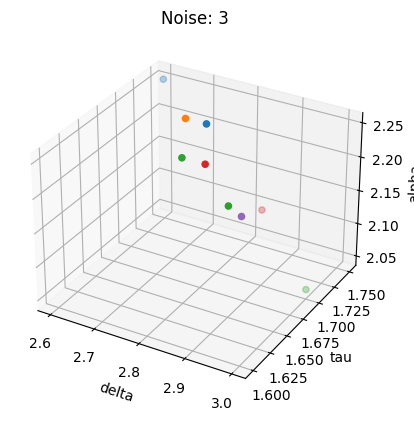

In [61]:
noise = 3
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

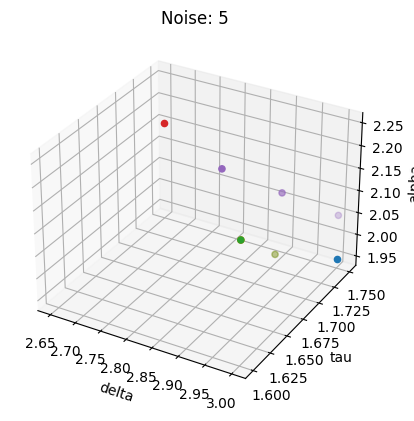

In [62]:
noise = 5
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

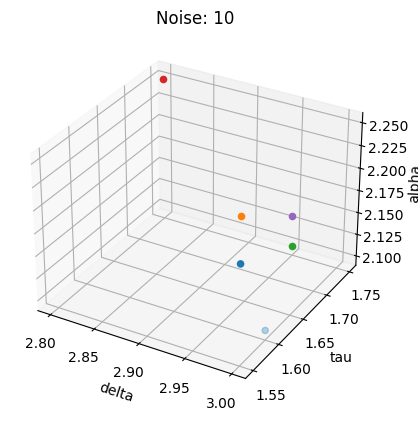

In [63]:
noise = 10
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()